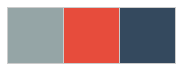

In [8]:
%matplotlib inline

import pandas as pd
import xarray as xr
import os

import glob

import matplotlib.pyplot as plt
import seaborn as sns

colors = ["#95a5a6", "#e74c3c", "#34495e"]
sns.palplot(sns.color_palette(colors))

sns.set_style('whitegrid')
sns.set_context('paper')

In [9]:
vic5_data = {}
vic4_data = {}
obs_data = {}

snow_files = glob.glob('/raid2/ymao/vic5_testing/output/science_test_Stehekin/release.5.0.1/science/science_test_snotel/results/outfile_*')

for fname in snow_files:
    xy = tuple(os.path.splitext(os.path.basename(fname))[0].split('_')[-2:])
    vic5_data[xy] = pd.read_table(fname, comment='#', parse_dates=[[0, 1, 2]], index_col=0)['OUT_SWE']
    
    fname4 = '/raid2/ymao/vic5_testing/output/science_test_Stehekin/VIC4.2/science/science_test_snotel/results/outfile_%s_%s.txt' % xy
    vic4_data[xy] = pd.read_table(fname, comment='#', parse_dates=[[0, 1, 2]], index_col=0)['OUT_SWE']
    
    obs_name = '/raid2/jhamman/projects/VIC5/VIC_test_data/datasets/snotel/observations/snotel_swe_%s_%s.txt' % xy
    obs_data[xy] = pd.read_table(obs_name, sep=' ', header=None, parse_dates=[[0, 1, 2]], names=['Year', 'Month', 'Day', 'SWE'], index_col=0)['SWE']


In [10]:
obs_df = pd.DataFrame(obs_data)
vic5_df = pd.DataFrame(vic5_data)
vic4_df = pd.DataFrame(vic4_data)

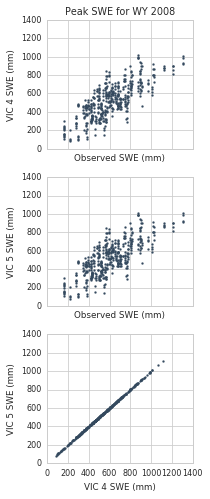

In [11]:
scat_kwargs = {'s': 4, 'color': colors[2]}

fig, axes = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(3, 7))

axes[0].scatter(obs_df.max(axis=0), vic4_df.max(axis=0), **scat_kwargs)
axes[0].set_ylabel('VIC 4 SWE (mm)')
axes[0].set_xlabel('Observed SWE (mm)')

axes[1].scatter(obs_df.max(axis=0), vic5_df.max(axis=0), **scat_kwargs)
axes[1].set_ylabel('VIC 5 SWE (mm)')
axes[1].set_xlabel('Observed SWE (mm)')

axes[2].scatter(vic4_df.max(axis=0), vic5_df.max(axis=0), **scat_kwargs)
axes[2].set_ylabel('VIC 5 SWE (mm)')
axes[2].set_xlabel('VIC 4 SWE (mm)')

for ax in axes.flatten():
    plt.sca(ax)
    plt.ylim(0, 1400)
    plt.xlim(0, 1400)

axes[0].set_title('Peak SWE for WY 2008')
fig.tight_layout()

fig.savefig('../figs/VIC_science_tests_SWE.png', dpi=300)

In [12]:
def get_fluxnet_lat_lon(obs_dir, subdir):

    # get CSV file from site directory to get lat/lng for site
    try:
        site_csv_file = glob.glob(os.path.join(obs_dir, subdir, 'AMF*.csv'))[0]
    except IndexError:
        site_csv_file = glob.glob(os.path.join(obs_dir, subdir, 'us*.csv'))[0]
    with open(site_csv_file) as f:
        second_line = list(f)[1]

    # parse line from header to get lat/lng
    str_split = tsplit(second_line,
                       ('Latitude: ', 'Longitude: ', 'Elevation (masl): '))
    lat = str_split[1].strip()
    lng = str_split[2].strip()

    return lat, lng


def read_fluxnet_obs(subdir, science_test_data_dir):

    # column names for DataFrame (same as VIC variable names)
    fluxnet_names = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'PREC', 'AIR_TEMP',
                     'SWDOWN', 'LWDOWN', 'OUT_REL_HUMID', 'PRESSURE', 'WIND',
                     'OUT_EVAP', 'SOIL_TEMP_DEPTH1', 'SOIL_TEMP_DEPTH2',
                     'SOIL_TEMP_DEPTH3', 'SOIL_TEMP_DEPTH4',
                     'SOIL_TEMP_DEPTH5', 'OUT_SOIL_MOIST1', 'OUT_SOIL_MOIST2',
                     'OUT_SOIL_MOIST3', 'OUT_SOIL_MOIST4', 'OUT_SOIL_MOIST5',
                     'OUT_SOIL_TEMP1', 'OUT_SOIL_TEMP2', 'OUT_SOIL_TEMP3',
                     'OUT_SOIL_TEMP4', 'OUT_SOIL_TEMP5', 'OUT_SWNET',
                     'OUT_LWNET', 'OUT_SENSIBLE', 'OUT_LATENT',
                     'OUT_GRND_FLUX']

    filename = '%s.stdfmt.hourly.local.txt' % subdir
    # read in data with -9999.0000 as NaNs
    obs_dir = os.path.join(science_test_data_dir, 'inputdata',
                           'ec_flux_towers', 'obs')
    ecflux_df = pd.read_csv(os.path.join(obs_dir, subdir, filename),
                            skiprows=0,
                            delim_whitespace=True,
                            header=None,
                            names=fluxnet_names,
                            na_values=-9999.0000)

    # add datetime index
    time_cols = ['YEAR', 'MONTH', 'DAY']
    ecflux_df.index = pd.to_datetime(ecflux_df[time_cols])

    if 'HOUR' in ecflux_df:
        ecflux_df.index += pd.Series(
            [pd.Timedelta(s, unit='h') for s in ecflux_df['HOUR']],
            index=ecflux_df.index)
        time_cols.append('HOUR')

    # remove year, day columns of DataFrame
    ecflux_df.drop(time_cols, inplace=True, axis=1)

    return ecflux_df

In [13]:
vic5_data = {}
vic4_data = {}
obs_data = {}
site_names = {}

def check_site_files(obs_dir, subdir):
    return len(os.listdir(os.path.join(obs_dir, subdir))) > 0
def tsplit(string, delimiters):
    '''Behaves like str.split but supports multiple delimiters. '''

    delimiters = tuple(delimiters)
    stack = [string]

    for delimiter in delimiters:
        for i, substring in enumerate(stack):
            substack = substring.split(delimiter)
            stack.pop(i)
            for j, _substring in enumerate(substack):
                stack.insert(i + j, _substring)

    return stack


obs_dir = '/raid/gergel/VIC5_test_data/science/inputdata/ec_flux_towers/obs/'
for subdir in os.listdir(obs_dir):
    
    if check_site_files(obs_dir, subdir):
        lat, lng = get_fluxnet_lat_lon(obs_dir, subdir)
        xy = lat, lng
        print(subdir, lat, lng)
        
        try:
       
            fname5 = '/raid2/ymao/vic5_testing/output/science_test_Stehekin/release.5.0.1/science/science_test_fluxnet/results/en_bal_{0:4.4f}_{1:4.4f}.txt'.format(float(lat), float(lng))
            vic5_data[xy] = pd.read_table(fname5, comment='#', parse_dates=[[0, 1, 2]], index_col=0)
        except:
            print('vic4', fname5)
        try:
            fname4 = '/raid2/ymao/vic5_testing/output/science_test_Stehekin/VIC4.2/science/science_test_fluxnet/results/en_bal_{0:4.4f}_{1:4.4f}.txt'.format(float(lat), float(lng))
            vic4_data[xy] = pd.read_table(fname, comment='#', parse_dates=[[0, 1, 2]], index_col=0)
        except:
            print('vic5', fname4)
            
        obs_data[xy] = read_fluxnet_obs(subdir, '/raid/gergel/VIC5_test_data/science/')
        
        site_names[xy] = subdir
        

AR1 36.4267 -99.42
AR2 36.6358 -99.5975
ARB 35.5497 -98.0402
ARC 35.5465 -98.0401
vic4 /raid2/ymao/vic5_testing/output/science_test_Stehekin/release.5.0.1/science/science_test_fluxnet/results/en_bal_35.5465_-98.0401.txt
ARM 36.6058 -97.4888
AUD 31.5907 -110.5092
vic4 /raid2/ymao/vic5_testing/output/science_test_Stehekin/release.5.0.1/science/science_test_fluxnet/results/en_bal_31.5907_-110.5092.txt
BKG 44.3453 -96.8362
BLK 44.158 -103.65
BLO 38.8953 -120.6328
BO1 40.0062 -88.2904
BO2 40.0061 -88.291867
vic4 /raid2/ymao/vic5_testing/output/science_test_Stehekin/release.5.0.1/science/science_test_fluxnet/results/en_bal_40.0061_-88.2919.txt
BR1 41.6915 -93.6914
BR3 41.9747 -93.6936
COP 38.09 -109.39
CTN 43.95 -101.8466
DIA 37.6773 -121.5296
FMF 35.1426 -111.7273
FPE 48.3077 -105.1019
FR2 29.9495 -97.9962
FR3 29.94 -97.99
FUF 35.089 -111.762
FWF 35.4454 -111.7718
GLE 41.3644 -106.2394
GOO 34.2547 -89.7735
vic4 /raid2/ymao/vic5_testing/output/science_test_Stehekin/release.5.0.1/science/scie

In [14]:
def clean_keys(df):
    d = {key: key.strip() for key in df.keys()}
    return df.rename(columns=d)

In [15]:
class TaylorDiagram(object):
    """Taylor diagram: plot model standard deviation and correlation
    to reference (data) sample in a single-quadrant polar plot, with
    r=stddev and theta=arccos(correlation).
    """

    def __init__(self, refstd, fig=None, rect=111, label='_', smax_factor=1.75):
        """Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using mpl_toolkits.axisartist.floating_axes. refstd is
        the reference standard deviation to be compared to.
        """

        from matplotlib.projections import PolarAxes
        from mpl_toolkits.axisartist import floating_axes
        from mpl_toolkits.axisartist import grid_finder

        self.refstd = refstd  # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.concatenate((np.arange(10) / 10., [0.95, 0.99]))
        tlocs = np.arccos(rlocs)  # Conversion to polar angles
        gl1 = grid_finder.FixedLocator(tlocs)  # Positions
        tf1 = grid_finder.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent
        self.smin = 0
        self.smax = smax_factor * self.refstd

        ghelper = floating_axes.GridHelperCurveLinear(
            tr, extremes=(0, np.pi / 2,  # 1st quadrant
                          self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = floating_axes.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")  # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")  # "Y axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction("left")

        ax.axis["bottom"].set_visible(False)  # Useless

        # Contours along standard deviations
        ax.grid(False)

        self._ax = ax  # Graphical axes
        self.ax = ax.get_aux_axes(tr)  # Polar coordinates

        # Add reference point and stddev contour
        l = self.ax.plot([0], self.refstd, 'k*',
                         ls='', ms=10, label=label)
        t = np.linspace(0, np.pi/2)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.sample_points = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """Add sample (stddev,corrcoeff) to the Taylor diagram. args
        and kwargs are directly propagated to the Figure.plot
        command."""

        l = self.ax.scatter(np.arccos(corrcoef), stddev,
                            *args, **kwargs)  # (theta, radius)
        self.sample_points.append(l)

        return l

    def add_contours(self, levels=5, **kwargs):
        """Add constant centered RMS difference contours."""

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, np.pi / 2))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2 * self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

In [16]:
def std_ratio(mod, obs):
    std_obs = obs.std()
    std_mod = mod.std()
    
    return std_mod / std_obs
    

def correlation_coef(mod, obs):
    return obs.corr(mod)

In [17]:
def preproc_series(obs, mod, align=False, rule=None):
    
    if align:
        obs, mod = obs.align(mod, join='inner')
    
    if rule is not None:
        obs = obs.resample(rule).mean()
        mod = mod.resample(rule).mean()
    
    return obs, mod
    

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


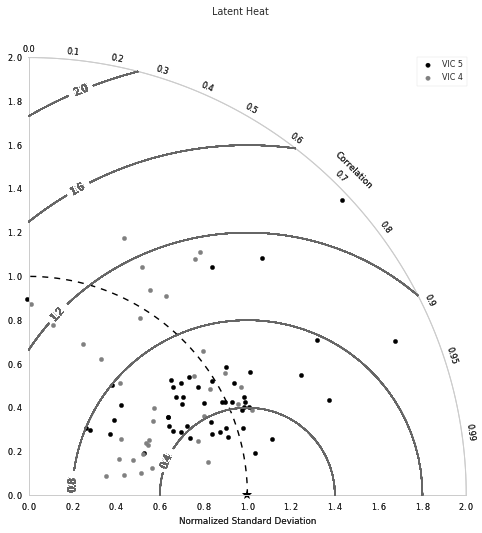

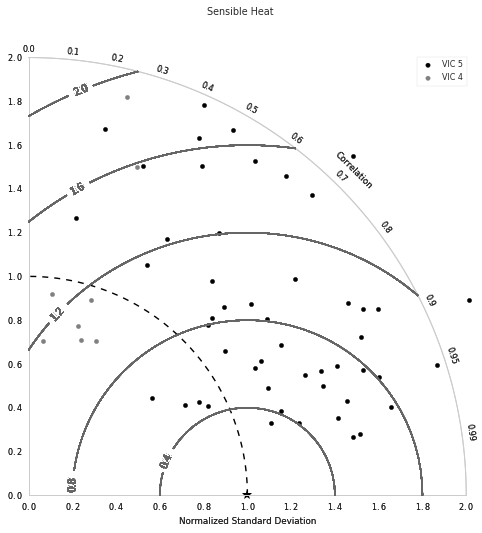

In [18]:
import numpy as np

for var, title in [('OUT_LATENT', 'Latent Heat'), ('OUT_SENSIBLE', 'Sensible Heat')]:
    obs_df = pd.DataFrame({k: clean_keys(df)[var] for k, df in obs_data.items()})
    vic5_df = pd.DataFrame({k: clean_keys(df)[var] for k, df in vic5_data.items()})
    vic4_df = pd.DataFrame({k: clean_keys(df)[var] for k, df in vic4_data.items()})


    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(title)
    taylor = TaylorDiagram(1., fig=fig, smax_factor=2)
    hdict = {}
    for site in vic5_df:

        obs, mod = preproc_series(obs_df[site], vic5_df[site], rule='MS')
        c0 = correlation_coef(mod, obs)
        s0 = std_ratio(mod, obs)
        hdict['VIC 5'] = taylor.add_sample(s0, c0, color='black')

        obs, mod = preproc_series(obs_df[site], vic4_df[site], rule='MS')
        c1 = correlation_coef(mod, obs)
        s1 = std_ratio(mod, obs)
        hdict['VIC 4'] = taylor.add_sample(s1, c1, color='grey')

        c = taylor.add_contours(colors='0.4', linewidths=1.25, zorder=8)
        plt.clabel(c, c.levels, fmt='%.1f', zorder=11)

        ax = plt.gca()
        ax.axis["left"].label.set_text("Normalized Standard Deviation")

        plt.legend(hdict.values(), hdict.keys(), frameon=True)
        
    fig.savefig('../figs/VIC_science_tests_%s.png' % var, dpi=300)

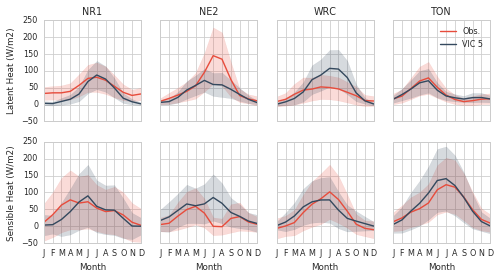

In [21]:
n = 4
top_n = (obs_df - vic5_df).notnull().sum().sort_values(ascending=False).ix[:n].index

fig, axes = plt.subplots(2, n, sharex=True, sharey=True, figsize=(8, 4))


for i, (var, title) in enumerate([('OUT_LATENT', 'Latent Heat (W/m2)'), ('OUT_SENSIBLE', 'Sensible Heat (W/m2)')]):
    obs_df = pd.DataFrame({k: clean_keys(df)[var] for k, df in obs_data.items()})
    vic5_df = pd.DataFrame({k: clean_keys(df)[var] for k, df in vic5_data.items()})
    vic4_df = pd.DataFrame({k: clean_keys(df)[var] for k, df in vic4_data.items()})

    for j, site in enumerate(top_n):    
        obs = obs_df[site]
        mod = vic5_df[site]

        ax = axes[i, j]
        og = obs.groupby(lambda x: x.month)
        mean = og.mean()
        mean.plot(ax=ax, c=colors[1], label='Obs.')
        std = og.std()
        ax.fill_between(std.index, mean - 0.5*std, mean + 0.5*std, color=colors[1], alpha=0.2)

        mg = mod.groupby(lambda x: x.month)
        mean = mg.mean()
        mean.plot(ax=ax, c=colors[2], label='VIC 5')
        std = mg.std()
        ax.fill_between(std.index, mean - 0.5*std, mean + 0.5*std, color=colors[2], alpha=0.2)
        
        ax.set_ylabel(title)
        
        axes[1, j].set_xlabel("Month")
        
        axes[0, j].set_title(site_names[site])
        
        ax.set_xticks(np.arange(1, 13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        
axes[0, -1].legend()

fig.savefig('../figs/VIC_science_tests_')